In [1]:
#Python Language Version 

from platform import python_version
print('Versão da Linguagem Python Usada neste projeto:', python_version())

Versão da Linguagem Python Usada neste projeto: 3.8.5


# Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python

### Projeto - Qual o Efeito da Legalização da Maconha na Taxa de Criminalidade ao Longo do Tempo?

![Rodolfo Terra](https://raw.githubusercontent.com/rodolffoterra/Projct_Marijuana_Legalization_TS/main/imagnes/layout5.png)

### Definição do Problema

Em 2016, os eleitores da Califórnia nos EUA aprovaram a Proposição 64, que legalizou o uso recreativo da maconha no estado. Neste link você encontra os detalhes sobre a aprovação da Proposição 64:

<a href="https://ballotpedia.org/California_Proposition_64,_Marijuana_Legalization_(2016)">California Proposition 64, Marijuana Legalization (2016)</a>

Os opositores à medida apresentaram cinco principais objeções à mudança no Guia Oficial de Informações do Eleitor do estado. Eles argumentaram que a legalização:

- (1) Dobraria o número de mortes nas rodovias.
- (2) Permitiria o cultivo de maconha perto de escolas e parques.
- (3) Aumentaria a atividade do mercado negro e do cartel.
- (4) Prejudicaria as comunidades pobres com problemas de dependência por meio do influxo de novos pontos de vendas de maconha.
- (5) Aumentaria a criminalidade ao longo do tempo, especialmente nas áreas próximas aos pontos de venda de maconha legalizada (cada ponto de venda de maconha legalizada é chamado de marijuana dispensary). 

Vamos realizar uma análise de dados com base em séries temporais e análises geoespaciais, além de outras técnicas exploratórias mais gerais, para examinar se essas previsões se tornaram realidade em Los Angeles desde que a legalização entrou em vigor. Nosso foco principal será nos dados disponíveis sobre detenções por crimes relacionados à maconha e na taxa geral de crimes nas proximidades de dispensários. Vamos focar principalmente nos itens 2, 4 e 5 acima.

Os dados usados neste projeto estão disponíveis publicamente e são oferecidos pelo portal de dados abertos do governo de Los Angeles.

Você é favor ou contra a legalização da Maconha? Acompanhe o projeto passo a passo, leia atentamente cada comentário e então emita sua opinião com base em dados.

Começaremos agora a Parte 5. Usaremos os 4 arquivos csv gerados na Parte 2:

- df_crimes.csv
- df_escolas.csv
- df_lojas.csv
- df_prisoes_parte2.csv

# Sumário:

* <p><a href="#C2">Modelage Preditiva</a></p>

- Análise de Séries Temporais

- Conclusões Finais

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [2]:
# The new versions of Pandas and Matplotlib bring several warning messages to the developer.; Let's disable this
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data Manipulation and previw
import math
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from scipy import stats

# Import for Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Imports for Times Series Analysis
import pickle
import calendar
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf

# Import for bformatting graphics
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Versions of packages used in this jupyter notebook
%reload_ext watermark
%watermark -a "Rodolfo Terra - Ciência de Dados" --iversions

Author: Rodolfo Terra - Ciência de Dados

matplotlib : 3.3.2
numpy      : 1.19.2
sklearn    : 0.23.2
statsmodels: 0.12.0
sys        : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas     : 1.1.3
scipy      : 1.5.2



<a name="C2"></a><h1>Modelagem Preditiva</h1>

Vamos iniciar nosso trabalho criando um modelo de Machine Learning para classificação e compreendendo quais são as variáveis mais relevantes para prever a ocorrência de prisões.

In [4]:
# # Loading prison data
df_prisoes = pd.read_csv('dados/df_prisoes_parte2.csv')

In [5]:
# Shape
df_prisoes.shape

(6226, 14)

In [6]:
# We preview a sample of data
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,3,13,4,8
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4


In [7]:
# We have cerated a list of reasons for arrests
charge_description_list = list(df_prisoes['Charge Description'].unique())

In [8]:
# We sort the list
charge_description_list.sort()

In [9]:
# Data
charge_description_list

['attempt - sell/furnish/etc marijuana',
 'cultivate >6 marij plants viol envrnt law',
 'cultivating <6 marijuana plants',
 'furnishing marijuana to minor over 14 yrs',
 'give/transport/etc < 28.5 grams marijuana',
 'induce/etc minor to use/sell marijuana',
 'minor poss 28.5+ grams marijuana/school',
 'minor poss < 28.5 grams marijuana/school',
 'poss for sale of marijuana to a minor',
 'poss marijuana or concentrated cannabis',
 'poss of more than 28.5 grams of marijuana',
 'poss open cont/packg marij drivr/passnger',
 'poss/sale marij ovr 21 employ per 20/belw',
 'poss/smoke/ingest marij school/daycare/yc',
 'possess 28.5 grams or less of marijuana',
 'possess 28.5 grams or less of marijuana**',
 'possess marijuana for sale',
 'possess marijuana for sale under age 18',
 'possess of marijuana while driving veh',
 'possession marijuana for sale',
 'possession of marijuana in school',
 'sale/offer to sell/transport marijuana',
 'sale/trans >28.5g marijuana or >4g',
 'sale/transport mari

Agora criaremos nossa variável target (venda ou não de maconha).

In [10]:
# We apply map function to identify marijuana sale
target = df_prisoes['Charge Description'].map(lambda x: 'sell' if 'sale' in x else x)

In [11]:
# So we indentified whether or not marijuana was sold
target = target.map(lambda x: 'sell' if 'sell' in x else x)
target = target.map(lambda x: 'not sell' if 'sell' not in x else x)

In [12]:
# We count the records for each class and show them as a proportion
target.value_counts(normalize = True)

sell        0.616929
not sell    0.383071
Name: Charge Description, dtype: float64

Como as classes são um pouco desequilibradas, vamos estratificá-las para que haja a mesma proporção de observações de 'venda' e 'não venda' nos conjuntos de dados de treino e teste, mais a frente.

In [13]:
# Include the variablçe in the dataframe
df_prisoes['target'] = target

In [14]:
# We do the encoding replacing the classes with valçues 0 or 1
df_prisoes['target'] = df_prisoes['target'].map(lambda x: 1 if x == 'sell' else 0)

In [15]:
# Data
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha,target
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5,1
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,8,12,2,5,1
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,3,13,4,8,1
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0,1
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4,1


Variável target incluída. Vamos checar algumas correlações.

In [16]:
# Correlation between the distance variable from the point of sale
df_prisoes[['loja_0.5_milha','loja_1_milha']].corr()

,loja_0.5_milha,loja_1_milha
loja_0.5_milha,1.000000,0.812163
loja_1_milha,0.812163,1.000000


As variáveis estão altamente correlacionadas e isso é ruim para o modelo. 

Precisamos remover uma variável de cada par que avaliamos.

In [17]:
# Remove variables and put hte rest bin X
X = df_prisoes.drop(['Arrest Date', 'Charge Description', 'target', 'loja_0.5_milha', 'escola_0.5_milha'], 1)

In [18]:
# We create dummy variables for categorial variables, because we only work with numeric variables
X = pd.get_dummies(X)

In [19]:
# Data
X.head()

,Time,Age,latitude,longitude,loja_1_milha,escola_1_milha,Area Name_77th Street,Area Name_Central,Area Name_Devonshire,Area Name_Foothill,...,Descent Code_F,Descent Code_G,Descent Code_H,Descent Code_O,Descent Code_P,Descent Code_W,Descent Code_X,Arrest Type Code_F,Arrest Type Code_I,Arrest Type Code_M
0,2015.0,29,34.1016,-118.3350,12,5,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2015.0,25,34.1016,-118.3350,12,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2115.0,42,34.0838,-118.3614,13,8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1045.0,26,33.9428,-118.4054,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5.0,27,34.1667,-118.3965,1,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# We separate y
y = df_prisoes['target']

In [21]:
# data
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [22]:
# Division in training and test data
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state = 42, stratify = y)

In [23]:
# Create the model
modelo_lr = LogisticRegression()

In [24]:
# Training the model
modelo_lr.fit(X_treino, y_treino)

LogisticRegression()

In [25]:
# Assessses accuracy in training
acc_treino = modelo_lr.score(X_treino, y_treino)
print(f'Acurácia em Treino: {round(acc_treino, 2) * 100}')

Acurácia em Treino: 89.0


In [26]:
# Assesses a acuracy in Test 
acc_teste = modelo_lr.score(X_teste, y_teste)
print(f'Acurácia em Teste: {round(acc_teste, 2) * 100}')

Acurácia em Teste: 90.0


Estamos com boa acurácia. Vamos extrair os coeficientes e realizar mais algumas análises.

In [27]:
# Beta coefficients of the model
beta = modelo_lr.coef_[0]

In [28]:
# Attributes
atributos = list(X.columns)

In [29]:
# We created a dataframe associating the coeficients to the attributes and adjusted the index
beta_df = pd.DataFrame({'atributos' : atributos, 'beta' : beta})
beta_df.set_index('atributos', inplace = True)

In [30]:
# Data
beta_df.head()

,beta
atributos,
Time,-0.000027
Age,-0.017298
latitude,-0.553670
longitude,-0.155785
loja_1_milha,-0.001657


In [31]:
# Let's extract the ODD Log
beta_df['log_odds'] = beta_df['beta'].map(lambda x: np.exp(x))

In [32]:
# We sort the data
beta_df = beta_df.sort_values('log_odds', ascending = False)

In [33]:
# Data
beta_df.head(10)

,beta,log_odds
atributos,,
Arrest Type Code_F,3.516854,33.678295
Area Name_Southeast,1.462502,4.316746
Descent Code_B,0.875014,2.398909
Area Name_Pacific,0.676805,1.967581
Sex Code_F,0.616998,1.853356
Area Name_Hollywood,0.269063,1.308738
Area Name_Harbor,0.263483,1.301455
Area Name_77th Street,0.187661,1.206424
Area Name_Central,0.178298,1.195181


Todas as variáveis são relevantes para a previsão de prisão por venda de maconha.

In [34]:
# Let's check the school records 1 mile away
beta_df[beta_df.index == 'escola_1_milha']

,beta,log_odds
atributos,,
escola_1_milha,0.027373,1.027751


O modelo de Regressão Logística permite extrair não apenas previsões de classe, mas também as probabilidades. Vejamos que análises podemos fazer com isso.

In [35]:
# Probabilities of arrest for manijuana sales (target class = 1)
prob_prisao_vendas = modelo_lr.predict_proba(X_teste)[:,1]

In [36]:
# Probabilities
prob_prisao_vendas

array([0.11821339, 0.73863631, 0.96730131, ..., 0.98070318, 0.94495389,
       0.97047262])

In [37]:
# Creates a dataframe with real values and predicted probabilities
pred_df = pd.DataFrame({'Valores_reais': y_teste, 'valores_previstos':prob_prisao_vendas})

In [43]:
# Data
pred_df.head()

,Valores_reais,valores_previstos
1780,0,0.118213
2379,0,0.738636
3731,1,0.967301
6068,1,0.923919
4958,1,0.954287


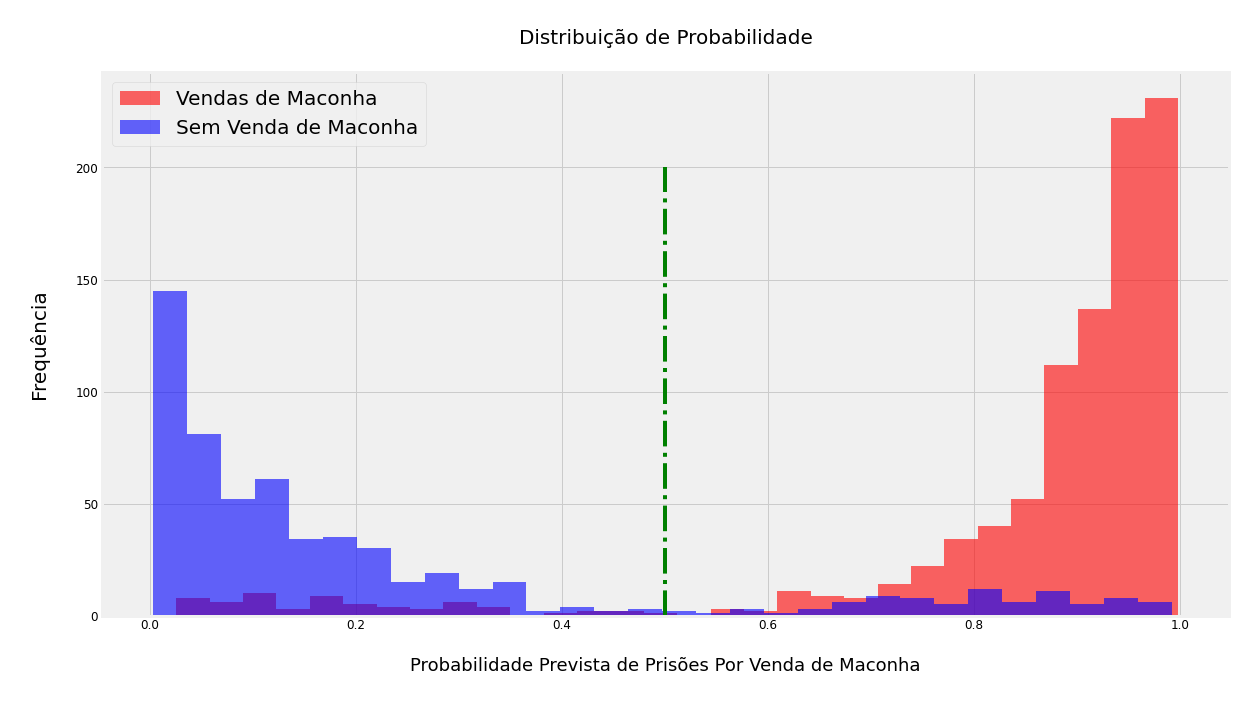

In [49]:
# Plotbability Distribution Plot

# Figure
plt.figure(figsize  = (18,10))

# Histogram of actual x predicted values for class 1
plt.hist(pred_df[pred_df['Valores_reais'] ==1]['valores_previstos'],
        bins = 30,
        color = 'r',
        alpha = 0.6,
        label = 'Vendas de Maconha')

# Histogram of actual x predicted values for class 1
plt.hist(pred_df[pred_df['Valores_reais'] == 0]['valores_previstos'],
        bins = 30,
        color = 'blue',
        alpha = 0.6,
        label = 'Sem Venda de Maconha')

# Chart centerline - vline - vertical line
plt.vlines(x = 0.5, ymin = 0, ymax = 200, color = 'green', linestyle = '-.')

# lables and caption
plt.title('\nDistribuição de Probabilidade\n', fontsize = 20)
plt.ylabel('\nFrequência\n', fontsize = 20)
plt.xlabel('\nProbabilidade Prevista de Prisões Por Venda de Maconha\n', fontsize = 18)
plt.legend(fontsize = 20);

Será que a proximidade de um Departamento de Polícia altera o resultado? Vamos analisar.

In [51]:
# Extract coefficients by area name
beta_df = beta_df[beta_df.index.str.contains('Area Name')].head(8)

In [53]:
# Data
beta_df.head()

,beta,log_odds
atributos,,
Area Name_Southeast,1.462502,4.316746
Area Name_Pacific,0.676805,1.967581
Area Name_Hollywood,0.269063,1.308738
Area Name_Harbor,0.263483,1.301455
Area Name_77th Street,0.187661,1.206424


Os Departamentos de Polícia na cidade de Los Angeles estão registrados aqui:

http://www.lapdonline.org/our_communities/content_basic_view/6279

Precisamos das coordenadas para os gráficos.

In [54]:
# Latitude of Police Departments in the City of Los Angeles
beta_df['latitude'] = [33.9383761,
                       34.097986,
                       33.9920067,
                       34.0443028,
                       33.7584097,
                       34.050264,
                       34.1195162,
                       34.1842023]

In [55]:
# Longitude of Police Departaments in the City of Las Angeles
beta_df['longitude'] = [-118.2749244,
                        -118.331013,
                        -118.4199295,
                        -118.4509833,
                        -118.2880336,
                        -118.291531,
                        -118.2497385,
                        -118.3021552]

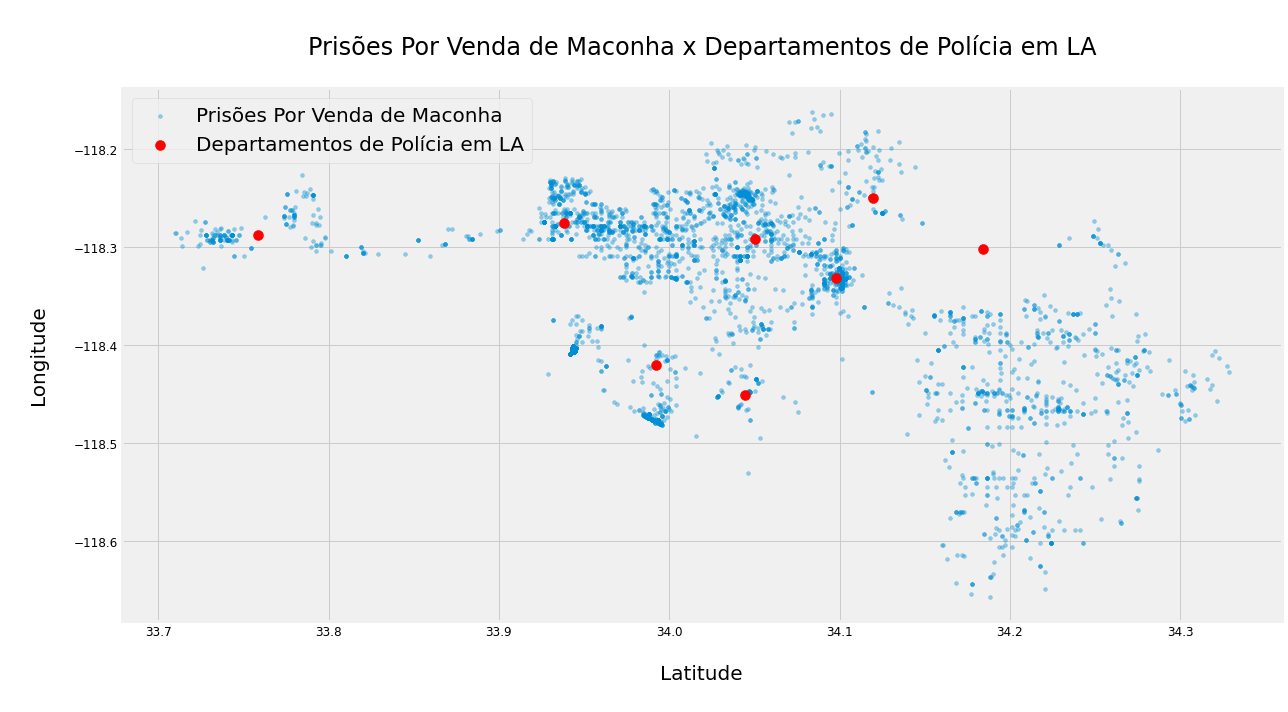

In [56]:
# Class 1 plot with main attributes versus marijuana arrests

# Figure
fig, ax = plt.subplots(figsize = (18,10))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] == 1]['latitude'], 
            df_prisoes[df_prisoes['target'] == 1]['longitude'], 
            s = 15, 
            alpha = 0.4,
            label = 'Prisões Por Venda de Maconha')

# Title, labels and caption
ax.scatter(beta_df['latitude'], beta_df['longitude'], color = 'red', label = 'Departamentos de Polícia em LA', s = 100)
plt.title('\nPrisões Por Venda de Maconha x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

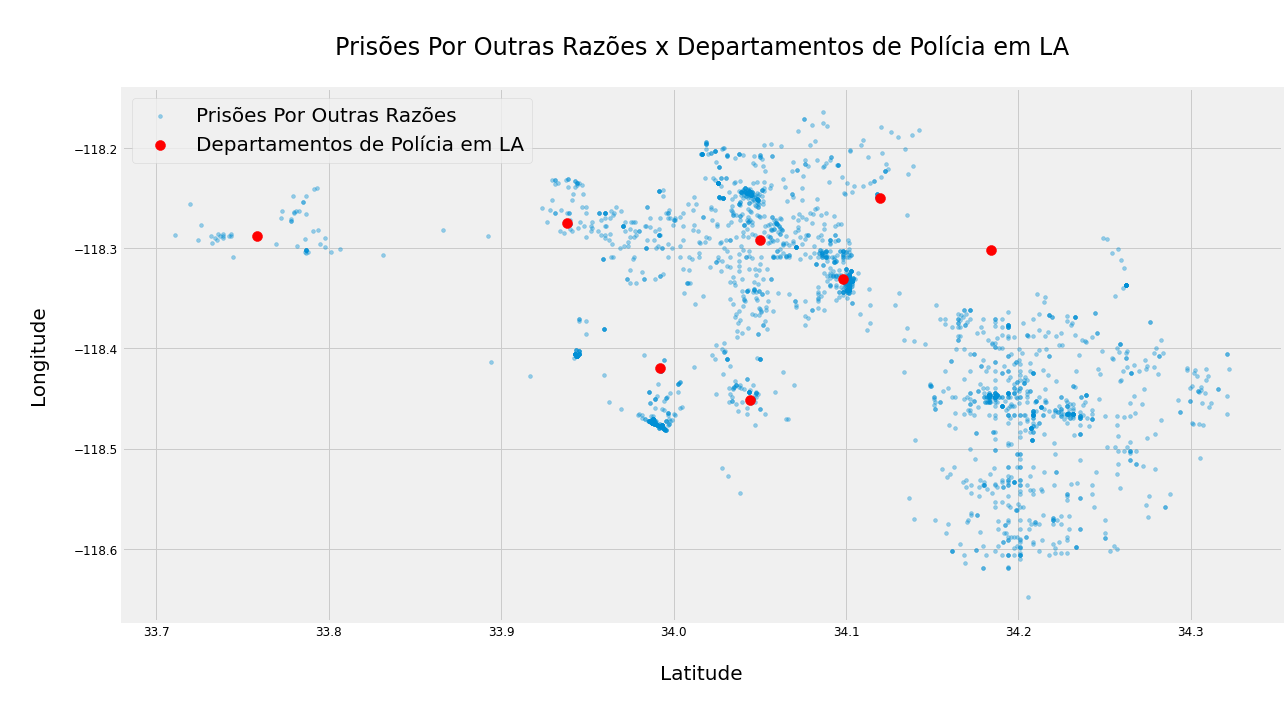

In [57]:
# Class 0 plot with main attributes versus marijuana arrests

# Figure
fig, ax = plt.subplots(figsize = (18,10))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] ==0]['latitude'], 
            df_prisoes[df_prisoes['target'] ==0]['longitude'], 
            s = 15, 
            alpha = 0.4,
            label = 'Prisões Por Outras Razões')

# Title, Legend and caption
ax.scatter(beta_df['latitude'], beta_df['longitude'], color = 'red', label = 'Departamentos de Polícia em LA', s = 100)
plt.title('\nPrisões Por Outras Razões x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

### Conclusão Final


Como resultado, o medo de exposição à maconha para crianças e menores parece não ser um fator. Existem duas classes: vender maconha e não vender maconha, e argumenta-se que a venda de maconha expõe mais crianças à maconha. A variável **escola_1_milha** é a contagem de escolas que estão dentro de 1 milha de cada prisão. Devido às chances de log de 'escola_1_milha' iguais a uma, ter uma escola a menos de 1,6 km de uma prisão é tão provável quanto a prisão por maconha estar relacionada à venda e a não venda.

<a href="https://github.com/rodolffoterra/Projct_Marijuana_Legalization_TS/blob/main/Projct_Marijuana_Legalization_TS_Part5.ipynb">Retornar o Projeto: Parte. 5</a>&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp;<a href="https://github.com/rodolffoterra/Projct_Marijuana_Legalization_TS/blob/main/Projct_Marijuana_Legalization_TS_Part5.ipynb">Dashboard</a>

![Rodolfo Terra](https://raw.githubusercontent.com/rodolffoterra/Projct_Marijuana_Legalization_TS/main/imagnes/logo.png)